# Lecture 10: Camera Calibration

**Introduction:** This notebook implements a method for camera calibration based on the Direct Linear Transform (DLT) formulation. The technique corresponds to Z. Zhang, "A Flexible New Technique for Camera Calibration,"" *IEEE Transactions on Pattern Analysis and Machine Intelligence*, 2000. Please refer to the [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr98-71.pdf) for more details. 

**Objective:** The goal of camera calibration is to estimate the camera intrinsic matrix $\mathbf{K} \in \mathbb{R}^{3\times 3}$ and the camera extrinsic parameters $\mathbf{R} \in SO(3)$ and $\mathbf{t} \in \mathbb{R}^3$ from a set of known 2D-3D point correspondences. As discussed in Lecture 9, this problem can be formulated as a system of linear equations, which can be solved with six 2D-3D point correspondences (five if skew of $\mathbf{K}$ is assumed to be zero). We will be applying concepts from linear algebra to solve the system of equations. In the end, we will use the camera intrinsic and extrinsic parameters to project 3D world points onto the image.

**Setup Instructions:** To run this notebook locally, please ensure the following dependencies are installed.
- System Dependencies: Python 3
- Python Packages: jupyter, numpy, matplotlib

In [4]:
from typing import Tuple, List

# Import packages.
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# NOTE: Corners are successfully ordered for the following images.
GOOD_IMGS = [0, 3, 8, 12, 13, 14, 15, 16, 22]

# Define paths.
DATA_PATH = os.path.join(os.getcwd(), 'chess_board')
IMG_PATHS = [os.path.join(DATA_PATH, 'board-{:02d}.png'.format(i+1)) for i in range(23)]
IMG_PATHS = [IMG_PATHS[i] for i in GOOD_IMGS]

# Define constants.
X_CORNERS = 9
Y_CORNERS = 7
W_PIXELS = 640
H_PIXELS = 480
D_SQUARE= 0.0205

## Step 1: Construct 2D-3D Point Correspondences
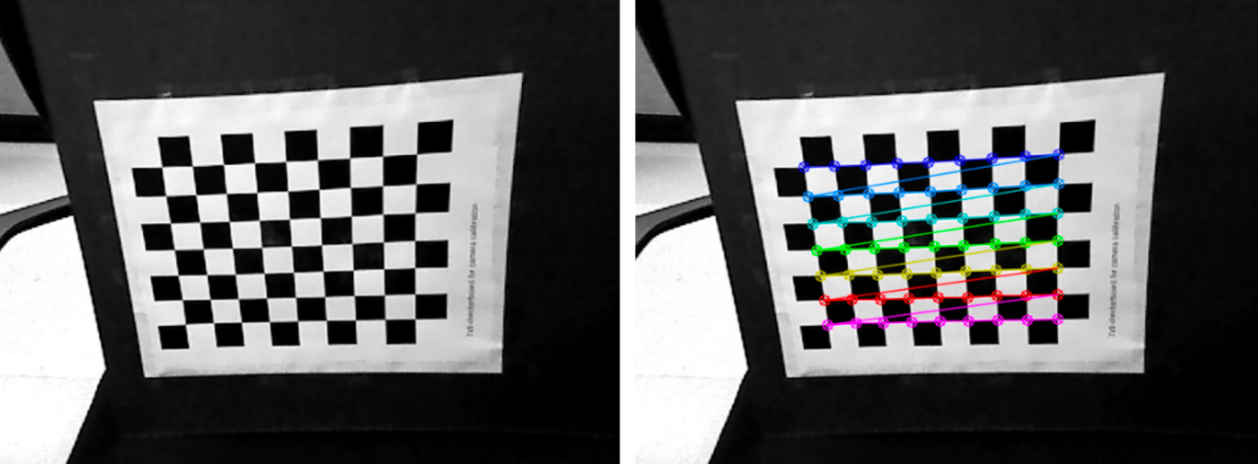

In [5]:
def generate_3D_world_coordinates(
    nx: int,
    ny: int,
    d_square: float,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Computes 3D points of chessboard cross-junctions in the world coordinate frame.
    
    Hint: It is up to you to decide where the world coordinate frame is situated.

    Args:
        nx: Number of chessboard cross-junctions along the x-axis.
        ny: Number of chessboard cross-junctions along the y-axis.
        d_square: Side length of each chessboard square in meters.

    Returns:
        X_world: (nx * ny,) Numpy array of world points along the x-axis.
        Y_world: (nx * ny,) Numpy array of world points along the y-axis.
        Z_world: (nx * ny,) Numpy array of world points along the z-axis.
    """
    X_world, Y_world = np.meshgrid(
        d_square * np.arange(nx),
        d_square * np.arange(ny)[::-1] # Flip y-axis: top to bottom.
    )
    X_world = X_world.flatten()
    Y_world = Y_world.flatten()
    Z_world = np.zeros_like(X_world)
    return X_world, Y_world, Z_world


def generate_2D_pixel_coordinates(
    nx: int,
    ny: int,
    img_path: str,
) -> Tuple[np.ndarray, np.ndarray]:
    """Computes 2D pixel coordinates chessboard cross-junctions.

    Args:
        nx: Number of chessboard cross-junctions along the x-axis.
        ny: Number of chessboard cross-junctions along the y-axis.
        img: Path to image.

    Returns:
        u_meas: (nx * ny,) Numpy array of pixel coordinates along the x-axis.
        v_meas: (nx * ny,) Numpy array of pixel coordinates along the y-axis.
    """
    img = cv2.imread(img_path, 0)

    # Following ROS-Perception implementation:
    # https://github.com/ros-perception/image_pipeline/blob/noetic/camera_calibration/src/camera_calibration/calibrator.py#L204
    flags = cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE | 0
    ok, corners = cv2.findChessboardCorners(img, (ny, nx), flags=flags)

    # NOTE: Ensure that points are ordered left-to-right, top-to-bottom.
    if not ok:
        raise ValueError("Could not find or order chessboard corners.")
    
    # The source implementation (below) does not always successfully order the corners.
    # if corners[0, 0, 1] > corners[-1, 0, 1]:
    #     corners = np.copy(np.flipud(corners))
    
    # Custom implementation for ordering corners that works on some of the images.
    corners = corners.squeeze()
    u_meas = np.flipud(corners[:, 0].reshape(9, 7).T).flatten()
    v_meas = np.flipud(corners[:, 1].reshape(9, 7).T).flatten()
    v_meas = H_PIXELS - v_meas
    
    return u_meas, v_meas

In [6]:
# Call generate_3D_world_coordinates for 3D world coordinates.
# NOTE: The same 3D world coordinates are used for all images.
X_world, Y_world, Z_world = generate_3D_world_coordinates(X_CORNERS, Y_CORNERS, D_SQUARE)

# Call generate_2D_pixel_coordinates for 2D pixel coordinates.
# NOTE: The 2D pixel coordinates are different for each image.
u_meas = []; v_meas = []
for img_path in IMG_PATHS:
    u, v = generate_2D_pixel_coordinates(X_CORNERS, Y_CORNERS, img_path)
    u_meas.append(u); v_meas.append(v)
u_meas = np.array(u_meas); v_meas = np.array(v_meas)

## Step 2: Compute Intrinsics \& Extrinsics

In [7]:
def compute_homography(
    u: np.ndarray,
    v: np.ndarray,
    X: np.ndarray,
    Y: np.ndarray,
) -> np.ndarray:
    """Computes homography matrix, which is required to transform 3D world 
    coordinates to 2D pixel coordinates. The intrinsic and extrinsic parameters
    will be extracted from the homography in the folliwng functions.

    Args:
        u: (N,) pixel x-coordinates.
        v: (N,) pixel y-coordinates.
        X: (N,) 3D world x-coordinates.
        Y: (N,) 3D world y-coordinates.
    
    Returns:
        H: (3, 3) Homography matrix.
    """
    Mt = np.column_stack([X, Y, np.ones_like(X)]) 
    L = np.vstack(
        [
            np.hstack(
                [Mt, np.zeros_like(Mt), -np.expand_dims(u, -1) * Mt]
            ),
            np.hstack(
                [np.zeros_like(Mt), Mt, -np.expand_dims(v, -1) * Mt]
            ),
        ]
    )
    _, _, V = np.linalg.svd(L)
    h = V[-1]
    H = h.reshape(3, 3)
    
    return H


def compute_intrinsics(H: List[np.ndarray]) -> np.ndarray:
    """Computes camera intrinsics from a list of homographies.
    
    Args:
        H: List of (3, 3) homography matrices, one per calibration image.
    
    Returns:
        K: (3, 3) camera intrinsic matrix.
    """
    def v(H, i, j):
        return np.array(
            [
                H[0, i] * H[0, j],
                H[0, i] * H[1, j] + H[1, i] * H[0, j],
                H[1, i] * H[1, j],
                H[2, i] * H[0, j] + H[0, i] * H[2, j],
                H[2, i] * H[1, j] + H[1, i] * H[2, j],
                H[2, i] * H[2, j],
            ]
        )

    V = np.array(
        [v(H_k, 0, 1) for H_k in H] \
            + [v(H_k, 0, 0) - v(H_k, 1, 1) for H_k in H]
    )
    _, _, V_svd = np.linalg.svd(V)
    b = V_svd[-1]

    B11, B12, B22, B13, B23, B33 = b
    v0 = (B12 * B13 - B11 * B23) / (B11 * B22 - B12 * B12)
    lamb = B33 - (B13 * B13 + v0 * (B12 * B13 - B11 * B23)) / B11
    alpha = np.sqrt(lamb / B11)
    beta = np.sqrt(lamb * B11 / (B11 * B22 - B12 * B12))
    gamma = -B12 * alpha * alpha * beta / lamb
    u0 = gamma * v0 / beta - B13 * alpha * alpha / lamb
    K = np.array([[alpha, gamma, u0], [0, beta, v0], [0, 0, 1]])

    return K


def compute_extrinsics(K: np.ndarray, H: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Computes camera extrinsics from a homography and intrinsics.

    Args:
        K: (3, 3) camera intrinsic matrix.
        H: (3, 3) homography matrix.
    
    Returns:
        R: (3, 3) camera extrinsic rotation matrix.
        t: (3, 1) camera extrinsic translation vector.
    """
    AinvH = np.linalg.solve(K, H)
    lamb = 1 / np.linalg.norm(AinvH[:, 0])
    r1 = lamb * AinvH[:, 0]
    r2 = lamb * AinvH[:, 1]
    r3 = np.cross(r1, r2)
    t = lamb * AinvH[:, 2]

    Q = np.column_stack([r1, r2, r3])
    U, _, V = np.linalg.svd(Q)
    R = U.dot(V)

    return R, t

In [8]:
# Step A: Compute homography for each image.
H = []
for u, v in zip(u_meas, v_meas):
    H.append(compute_homography(u, v, X_world, Y_world))

# Step B: Compute intrinsics from homographies.
K = compute_intrinsics(H)

# Step C: Compute extrinsics from homographies and intrinsics for each image.
R = []
t = []
for H_k in H:
    R_k, t_k = compute_extrinsics(K, H_k)
    R.append(R_k)
    t.append(t_k)    

## Step 3: Project 3D Points \& Plot Results!

In [9]:
def plot_image_pixel_coordinates(
    u_meas: np.ndarray,
    v_meas: np.ndarray,
    u_pred: np.ndarray,
    v_pred: np.ndarray,
    img_path: str,
    img_num: int,
) -> None:
    """
    Plot image pixel coordinates against ground-truth.

    Args:
        u_meas: (N,) array of measured u-coordinates.
        v_meas: (N,) array of measured v-coordinates.
        u_pred: (N,) array of predicted u-coordinates.
        v_pred: (N,) array of predicted v-coordinates.
        img_path: Path to image.
        img_num: Image number.
    """
    _ = plt.figure(figsize=(12, 8))    
    plt.clf()
    ax = plt.subplot(121)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Chessboard {GOOD_IMGS[img_num] + 1}: Image")

    ax = plt.subplot(122)
    ax.plot(u_meas, v_meas, "r+", label="Measured (OpenCV)")
    ax.plot(u_pred, v_pred, "b+", label="Calibrated (DLT)")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.15, box.width, box.height * 0.85])
    ax.axis([0, W_PIXELS, 0, H_PIXELS])
    ax.set_title(f"Chessboard {img_num + 1}: Cross-Junctions")

    plt.gca().set_aspect("equal", adjustable="box")
    ax.legend(
        loc="lower center",
        bbox_to_anchor=(0.5, -0.3),
        fontsize="medium",
        fancybox=True,
        shadow=True,
    )
    

def transform_world_to_pixel(
    K: np.ndarray, R: np.ndarray, t: np.ndarray, P: np.ndarray
) -> np.ndarray:
    """Transforms 3D point in world coordinates to homogenous point in pixel coordinates.

    Note: Recall the convention, where R, t are the rotation and translation
          of the world frame with respect to the camera frame (not vice versa!)

    Args:
        K: (3, 3) camera intrinsic matrix.
        R: (3, 3) camera extrinsic rotation matrix.
        t: (3, 1) camera extrinsic translation vector.
        P: (3,) 3D point in world coordinates.

    Returns:
        p: (3,) homogenous point in pixel coordinates.
    """
    p = K.dot(R.dot(P) + t)
    return p

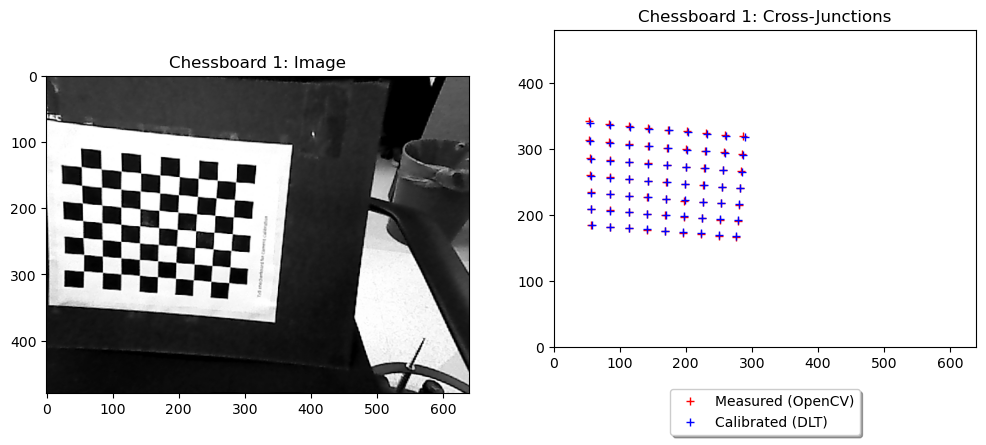

In [10]:
u_pred = np.zeros_like(u_meas)
v_pred = np.zeros_like(v_meas)
for i in range(u_pred.shape[0]):
    for j in range(u_pred.shape[1]):
        P_world = np.array([X_world[j], Y_world[j], Z_world[j]])
        p_pred = transform_world_to_pixel(K, R[i], t[i], P_world)
        u_pred[i, j] = p_pred[0] / p_pred[2]
        v_pred[i, j] = p_pred[1] / p_pred[2]
        
# Plot pixel coordinates against ground-truth.
# NOTE: Set img_num between 0 and 8.
img_num = 0
plot_image_pixel_coordinates(
    u_meas[img_num], 
    v_meas[img_num], 
    u_pred[img_num], 
    v_pred[img_num], 
    IMG_PATHS[img_num],
    img_num)
plt.show()